In [1]:
import numpy as np 

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit import Aer
from qiskit.primitives import Sampler, BackendSampler
from qiskit.circuit.library import TwoLocal
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Session, Options
from qiskit import transpile, QuantumCircuit
from qiskit_optimization.translators import to_docplex_mp
from docplex.mp.model import Model
from docplex.mp.model_reader import ModelReader
from qiskit_optimization.translators import from_docplex_mp

import gibbs_optimizer_modified as opt

In [2]:
mod = Model()
mod = ModelReader.read_model('../../lp_G0_lp_c/seq_1080_c.lp')

#convert linear program to qubo
qp = from_docplex_mp(mod)
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
#quboOp, offset = qubo.to_ising()
Q_info = qubo.objective.quadratic.coefficients.copy()
l_diag = qubo.objective.linear
for k in range(qp.get_num_vars()):
    Q_info[k,k] += l_diag[k]

Q = Q_info.tocoo()
scaling = np.abs(np.max(Q))
Q=Q/scaling #scale coefficients
Q_data = np.stack([Q.row, Q.col, Q.data], axis=1)
print(scaling)

281.99999999999994


In [3]:
target_mdl = QuadraticProgram()
target_mdl.read_from_lp_file('../../lp_G0_lp_c/seq_1080_c.lp')

N = target_mdl.get_num_vars()
print(N)
cplex_result = CplexOptimizer().solve(target_mdl)
cplex_optval = cplex_result.fval
cplex_xsol = cplex_result.x.astype(int)

print(
        '-'*110,
        '[CPLEX Result]',
        f'   optimal value: {cplex_optval:.3f}',
        f'   optimal solution (binary): {cplex_xsol}',
        f'   status: {cplex_result.status.name}',
        '-'*110,
        sep='\n'
    )

30
--------------------------------------------------------------------------------------------------------------
[CPLEX Result]
   optimal value: -91.500
   optimal solution (binary): [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1]
   status: SUCCESS
--------------------------------------------------------------------------------------------------------------


In [4]:
def objective(x):
    objval = x @ Q @ x
    return objval

In [5]:
num_qubits = qp.get_num_vars() 
print(f'number of system qubits: {num_qubits}')

number of system qubits: 30


In [6]:
reps = 2

ansatz = TwoLocal(
    num_qubits = num_qubits,
    rotation_blocks = 'ry', 
    entanglement_blocks = 'cz',
    entanglement = 'pairwise', 
    reps = reps,
    insert_barriers = True
    )

n_params = ansatz.num_parameters
print(f'number of params: {n_params}')

number of params: 90


In [7]:
shots = 2**13
backend = Aer.get_backend('aer_simulator_matrix_product_state')
backend.set_options()

sampler = BackendSampler(backend=backend)
sampler.set_options(shots=shots)

QuantumOptimizer = opt.Quantum_Optimizer()
QuantumOptimizer.set_optimizer(num_qubits, ansatz, sampler)
bin_init = np.random.choice([1, 0], size=num_qubits, p=[0.1, 0.9])
theta_initial = np.hstack([np.full(num_qubits, np.pi/2), np.zeros(num_qubits*ansatz.reps)])

In [8]:
import time
from collections import defaultdict
import pickle

prob_list = defaultdict(list)
theta = theta_initial
log = defaultdict(list)

for beta in [1.0]:
    for itrial in range(0, 10):
        st = time.time()
        opt_run = QuantumOptimizer.run(
            objective = objective, 
            qc_params_init = theta,
            scaling=scaling, #scaling param for Hamiltonian
            max_epoch = 2,  
            intermediate_result_display = True,
            refval = None,
            alpha = 1.0, #cVAR param
            beta = beta,
        )
        filename = 'log_b_mod_' + str(beta) + '_trial_' + str(itrial)
        with open('results/' + filename, 'wb') as fp:
            pickle.dump(opt_run['fval_log'], fp)
        
        print(time.time() - st)

epoch = 0 	 step = 0 	 best val = 1960.800 	 expectation = 77.049
epoch = 0 	 step = 1 	 best val = 1660.600 	 expectation = 71.637
epoch = 0 	 step = 2 	 best val = 1117.650 	 expectation = 71.804
epoch = 0 	 step = 3 	 best val = 556.900 	 expectation = 66.766
epoch = 0 	 step = 4 	 best val = 255.300 	 expectation = 67.215
epoch = 0 	 step = 5 	 best val = 255.300 	 expectation = 62.597
epoch = 0 	 step = 6 	 best val = 255.300 	 expectation = 58.273
epoch = 0 	 step = 7 	 best val = 255.300 	 expectation = 54.627
epoch = 0 	 step = 8 	 best val = 255.300 	 expectation = 50.338
epoch = 0 	 step = 9 	 best val = 255.300 	 expectation = 46.828
epoch = 0 	 step = 10 	 best val = 255.300 	 expectation = 42.528
epoch = 0 	 step = 11 	 best val = -25.400 	 expectation = 42.037
epoch = 0 	 step = 12 	 best val = -25.400 	 expectation = 37.323
epoch = 0 	 step = 13 	 best val = -25.400 	 expectation = 32.430
epoch = 0 	 step = 14 	 best val = -25.400 	 expectation = 32.417
epoch = 0 	 step 

KeyboardInterrupt: 

In [10]:
import pickle

for beta in [1.0]:
    for itrial in range(0, 1):
        filename = 'log_b_mod_' + str(beta) + '_trial_' + str(itrial)
        with open('results/' + filename, 'rb') as fp:
            log = pickle.load(fp)
log

[6.953191489361702,
 (5.975886524822695,
  77.04948278115995,
  -13.998142448383483,
  72.16500315564753),
 5.888652482269504,
 (3.9632978723404255, 71.6366681777588, -67.28045335239953, 71.65215430293526),
 3.9632978723404255,
 (3.951950354609929,
  71.80446993489859,
  -14.828756964750808,
  67.23067254681958),
 1.9748226950354608,
 (1.9748226950354608,
  66.76569823171005,
  -58.579367948808866,
  67.46548639392171),
 0.9053191489361702,
 (0.9053191489361702,
  67.21452680738129,
  -15.75787208234846,
  62.547393127874145),
 0.9053191489361702,
 (0.9053191489361702,
  62.59713914917457,
  -55.28849108956242,
  58.077774675518214),
 0.9053191489361702,
 (0.9053191489361702,
  58.27283553043407,
  -14.331698905532873,
  55.079494460085655),
 0.9053191489361702,
 (0.9053191489361702,
  54.62652150226853,
  -53.8471252942525,
  50.307682984264076),
 0.9053191489361702,
 (0.9053191489361702,
  50.33766780670013,
  -13.101415036755808,
  46.64444099588584),
 0.9053191489361702,
 (0.905319

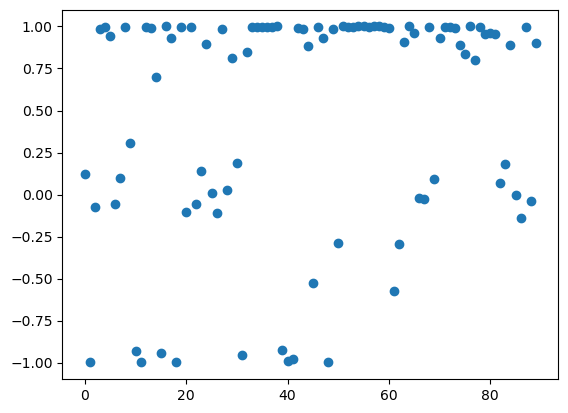

In [17]:
import matplotlib.pyplot as plt

plt.plot([np.cos(x) for x in opt_run['theta']], 'o')

In [ ]:
qc = ansatz.bind_parameters(opt_run['theta'])
qc.measure_all()

job = sampler.run(qc)
result = job.result()
quasi_dist = result.quasi_dists[0]
prob_dict = quasi_dist.binary_probabilities()
prob_list[beta].append(prob_dict)  

In [ ]:
from itertools import product
import matplotlib.pyplot as plt

ee = {}
prob = {}

bit_str = [''.join(p) for p in product('10', repeat=num_qubits)]

def energy(x):
    x = np.array(list(x)).astype(int)
    x = np.flip(x) 
    return x @ Q @ x

for beta in np.arange(0.5, 0.6, 0.1):
    Z = 0.0
    for elem in bit_str:
        ee[elem] = objective([int(i) for i in elem])
        prob[elem] = np.exp(-beta * ee[elem])
        Z+= prob[elem]
    
    prob_ee = {k:(v/Z) for (k,v) in zip(ee.values(), prob.values())}
    plt.plot(prob_ee.keys(), prob_ee.values(), 'o')
    plt.plot([energy(x) for x in prob_list[0.5][0].keys()], prob_list[0.5][0].values(), 'o')
    #plt.yscale('log')

In [ ]:
fid = 0.0
for bit_str, val in prob.items():
    if bit_str in prob_list[0.5][0].keys():
        fid+= prob[bit_str] * prob_list[0.5][0][bit_str]
fid

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table